## Tensorflow, Kerasを使わないCNN

Trainingデータは、Augumentorを使って作ったデータ2000x15<br />
Testデータは、train_data.npy

遅いので、nVidiaのGPUがある場合は、cupyを使う。<br />
学習時は、common.fonfigにあるGPUを変更する

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from common.config import GPU
if GPU:
    import cupy as np
else:
    import numpy as np

from dataset.katakana_arg import load_katakana_arg
from common.trainer import Trainer
from common.layers import *
import pickle
import time

### CNNを使ったモデルのクラス

In [2]:
class CNNNet:
    '''
    ネットワーク構成は下記の通り
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    '''

    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_2={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_3={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_4={'filter_num': 32, 'filter_size': 3, 'pad': 2, 'stride': 1},
                 conv_param_5={'filter_num': 64, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_6={'filter_num': 64, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 hidden_size=50, output_size=15):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか
        pre_node_nums = np.array([1 * 3 * 3, 16 * 3 * 3, 16 * 3 * 3, 32 * 3 * 3, 32 * 3 * 3, 64 * 3 * 3, 64 * 4 * 4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLUを使う場合に推奨される初期値

        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate(
                [conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx + 1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'],
                                                                                       pre_channel_num,
                                                                                       conv_param['filter_size'],
                                                                                       conv_param['filter_size'])
            self.params['b' + str(idx + 1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64 * 4 * 4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'],
                                       conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'],
                                       conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'],
                                       conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                                       conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                                       conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                                       conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        #self.layers.append(BatchNormalization(1. ,0.)
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        #self.layers.append(BatchNormalization(1. ,0.)
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        #self.layers.append(BatchNormalization(1. ,0.)
        self.layers.append(Dropout(0.5))

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t, train_flg=True):
        y = self.predict(x, train_flg)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def accuracy_and_loss(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0
        loss = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx, train_flg=False)
            loss += self.last_layer.forward(y, tt)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0], loss / (int(x.shape[0] / batch_size))

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        counter = 1
        for i, layer in enumerate(self.layers):
            if layer.hasWeight: #　今のところWeightをもっているものはBiasがあるので
                grads['W' + str(counter)] = layer.dW
                grads['b' + str(counter)] = layer.db
                counter += 1

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            if GPU:
                import numpy
                val = np.asnumpy(val) # 実際は、cupy.asnumpy()
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            if GPU:
                import numpy
                val = np.array(val) # 実際はcupy.array()
            self.params[key] = val

        counter = 1
        for i, layer in enumerate(self.layers):
            if layer.hasWeight: #　今のところWeightをもっているものはBiasがあるので
                layer.W = self.params['W' + str(counter)]
                layer.b = self.params['b' + str(counter)]
                counter += 1

### トレーナーを使ったメイン関数

In [3]:
start = time.time()

(x_train, t_train), (x_test, t_test) = load_katakana_arg(flatten=False)
print('x_train', x_train.shape, 't_train', t_train.shape)
print('x_test', x_test.shape, 't_test', t_test.shape)

network = CNNNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                      epochs=50, mini_batch_size=256,
                      optimizer='Adam', optimizer_param={'lr': 0.001})

train_acc_list, train_loss_list, test_acc_list, test_loss_list = trainer.train()
elapsed_time = time.time() - start

print("=============== Elapse Time ===============")
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")


x_train (30000, 1, 28, 28) t_train (30000, 15)
x_test (3000, 1, 28, 28) t_test (3000, 15)
Epoch: 1 ...........................................................
Epoch=1, Train Acc=0.7852, Train Loss=1.6212086044172267, Test Acc=0.866, Test Loss=1.3958464893544462
Test Loss improved from 1.7976931348623157e+308 to 1.3958464893544462
Save weight to epoch_000_train_acc_0.79_train_loss_1.62_test_acc_0.87_test_loss_1.40.pkl
Epoch: 2 ...........................................................
Epoch=2, Train Acc=0.9008, Train Loss=0.9263925878476679, Test Acc=0.9526666666666667, Test Loss=0.6518527657959804
Test Loss improved from 1.3958464893544462 to 0.6518527657959804
Save weight to epoch_001_train_acc_0.90_train_loss_0.93_test_acc_0.95_test_loss_0.65.pkl
Epoch: 3 ...........................................................
Epoch=3, Train Acc=0.9364, Train Loss=0.6021177250903001, Test Acc=0.9666666666666667, Test Loss=0.3720790815508715
Test Loss improved from 0.6518527657959804 to 0.3720790

Epoch: 25 ...........................................................
Epoch=25, Train Acc=0.9988333333333334, Train Loss=0.00783886776000192, Test Acc=1.0, Test Loss=0.0012523456866931882
Test Loss did not improved best= 0.0011846481745519015 current 0.0012523456866931882
Epoch: 26 ...........................................................
Epoch=26, Train Acc=0.9987, Train Loss=0.007600785485890743, Test Acc=1.0, Test Loss=0.001522506792523054
Test Loss did not improved best= 0.0011846481745519015 current 0.001522506792523054
Epoch: 27 ...........................................................
Epoch=27, Train Acc=0.9990333333333333, Train Loss=0.006992605725144318, Test Acc=1.0, Test Loss=0.0013248273693100983
Test Loss did not improved best=0.0011846481745519015 current=0.0013248273693100983
Epoch: 28 ...........................................................
Epoch=28, Train Acc=0.9992666666666666, Train Loss=0.0055174658027288504, Test Acc=1.0, Test Loss=0.0006491146133272315
Test

In [4]:
print(len(train_acc_list))
print(len(train_loss_list))
print(len(test_acc_list))
print(len(test_loss_list))

50
50
50
50


### matplotlib による描画

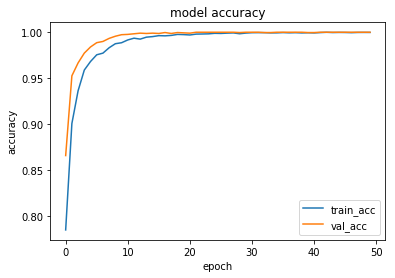

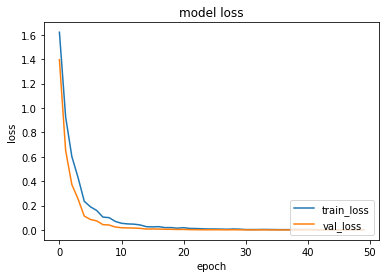

In [5]:
# 精度の履歴をプロット
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

# 損失の履歴をプロット
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='lower right')
plt.show()
